In [1]:
import numpy as np
import sympy as sy
from IPython.display import display
from matplotlib import pyplot as plt
from itertools import product
import pickle

#### Define functions and sympy variables

In [2]:
def spherical_to_cartesian(ang_coord_sample):
    cart_vec = []
    for i in range(len(cart_coords)):
        if i == 0:
            cart_coord = -np.cos(ang_coord_sample[i])
        elif i < (len(cart_coords) - 1):
            cart_coord = -np.cos(ang_coord_sample[i])
            for j in range(i):
                cart_coord = np.sin(ang_coord_sample[j]) * cart_coord
        else:
            cart_coord = -np.sin(ang_coord_sample[i-1])
            for j in range(i-1):
                cart_coord = np.sin(ang_coord_sample[j]) * cart_coord
        if abs(0.0 - cart_coord) < np.finfo(np.float64).eps:
            cart_coord = 0.0
        cart_vec.append(cart_coord)
    return cart_vec

def plot_surface(dims, ax_lims=[-5,5], interactive=False, cond='wav', inv_axis=[False,False,False]):
    if interactive:
        %matplotlib widget
    fig = plt.figure(figsize=(6,6))
    if dims == 2:
        ax = fig.add_subplot()
        ax.scatter(J_sub_k[0], J_sub_k[1], c='black')
    else:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(J_sub_k[0], J_sub_k[1], J_sub_k[2], c='black')
    x_lams = []
    for i in range(len(C_k)):
        params = [C_k[i], J_k[i], kappa]
        expr = -C_k[i]*kappa + J_k[i]
        x_lam = sy.lambdify(params, expr, 'numpy')
        x_lams.append(x_lam)
    for i in range(len(data[sy.sstr(C_k[0])])):
        if cond == 'wav':
            condition = np.isnan(data['kappa_cs']['wav'][i]) == False
            kappa_cs = np.extract(condition, data['kappa_cs']['wav'][i])
            color = 'red'
        else:
            condition = np.isnan(data['kappa_cs']['st'][i]) == False
            kappa_cs = np.extract(condition, data['kappa_cs']['st'][i]) 
            color = 'blue'
        for kappa_c in kappa_cs:
            coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j]), kappa_c) for j, x_lam in enumerate(x_lams)]
            ax.scatter(*zip(coords), c=color)
    ax.set_xlim(ax_lims[0],ax_lims[1])
    ax.set_ylim(ax_lims[0],ax_lims[1])
    if dims > 2: ax.set_zlim(ax_lims[0],ax_lims[1])
    ax.set_xlabel(M_sub_k[0])
    ax.set_ylabel(M_sub_k[1])
    if dims > 2: ax.set_zlabel(M_sub_k[2])
    if inv_axis[0]: ax.invert_xaxis()
    if inv_axis[1]: ax.invert_yaxis()
    if dims > 2:
        if inv_axis[2]:
            ax.invert_zaxis()

def store_sample(cond, kappa_arr):
    if cond == 'wav':
        kappa_arr = kappa_wavs
    else:
        kappa_arr = kappa_sts
    kappa_c_dir = []
    for kappa_c in kappa_arr:
        if np.isreal(kappa_c) and (kappa_c > 0):
            kappa_c_dir.append(kappa_c)
        else:
            kappa_c_dir.append(np.nan)
    if verbose: print('kappa_c_dir', kappa_c_dir)
    # Store critical kappas
    if cond == 'wav':
        data['kappa_cs']['wav'].append(kappa_c_dir)
    else:
        data['kappa_cs']['st'].append(kappa_c_dir)

# Define sympy symbols
u, w, v = sy.symbols("u w v")
a_u, a_v, a_w, b_u, c_u, c_v, d_v, d_w = sy.symbols("a_u a_v a_w b_u c_u c_v d_v d_w")
mu, nu, kappa, lamda = sy.symbols("mu nu kappa lamda")
D_u, D_v, D_w = sy.symbols("D_u D_v D_w")
J11, J12, J13, J21, J22, J23, J31, J32, J33 = sy.symbols('J11 J12 J13 J21 J22 J23 J31 J32 J33')
C11, C12, C13, C21, C22, C23, C31, C32, C33 = sy.symbols('C11 C12 C13 C21 C22 C23 C31 C32 C33')

#### Define model (i.e. J and C) and conditions

In [3]:
'''Hata example, chain web Holling type II. Theoretically meets wave instabliity 
   conditions as top predator diffusion rate is increased. '''
# Define nonlinear interaction terms
f = (a_u - b_u*u - c_u*(w/(u+mu))) * u
g = (a_v*(1 - c_v*(v/u)) - d_v*(w/(v+nu))) * v
h = (a_w * (1 - d_w*(w/v))) * w

# Define parameter values
param_vals = [(a_u,3.0), (a_v,6.0), (a_w,4.0), 
              (b_u,1.0), (c_u,1.0), (c_v,1.0), 
              (d_v,1.0), (d_w,0.25),
              (mu,0.25), (nu,0.25)]

# Solve for the uniform steady state
'''I get a different steady from Hata 2014, so I just 
   hardcode in the Jacobian values to J_sub below.'''
eq_vec = (sy.Eq(f.subs(param_vals),0), 
          sy.Eq(g.subs(param_vals),0), 
          sy.Eq(h.subs(param_vals),0))
var_vec = (u, v, w)
x0 = (1, 2.5, 10.2)
u_0, v_0, w_0 = sy.nsolve(eq_vec, var_vec, x0)

# Construct M matrix
J = sy.Matrix([[J11, J12, J13], 
               [J21, J22, J23], 
               [J31, J32, J33]])
# J_star = sy.Matrix([[sy.diff(f, u), sy.diff(f, v), sy.diff(f, w)],
#                [sy.diff(g, u), sy.diff(g, v), sy.diff(g, w)],
#                [sy.diff(h, u), sy.diff(h, v), sy.diff(h, w)]])
# J_sub = J_star.subs(param_vals + [(u, u_0), (v, v_0), (w, w_0)])
J_sub = sy.Matrix([[0.471, -0.813, 0.0],
                   [5.552, 0.962, -0.911],
                   [0.0, 16.0, -4.0]])
# J_sub = sy.Matrix([[0.0, 1.0, 1.0],
#                 [1.0, 0.0, 1.0],
#                [1.0, 1.0, 0.0]])
C = sy.Matrix([[C11, 0, 0], 
               [0, C22, 0], 
               [0, 0, C33]])
M = J_sub - kappa*C
M_sub = M
display(M)
M_star = sy.zeros(3,3)
for i,j in product(range(M.shape[0]), repeat=2):
    if C[i,j] != 0:
        M_star[i,j] = -C[i,j]*kappa
    else:
        M_star[i,j] = J_sub[i,j]

# Characteristic polynomial
p = M_star.charpoly(lamda)
p_coeffs = p.all_coeffs()

# Oscillatory and stationary instability conditions
I_wav = p_coeffs[3] - p_coeffs[1]*p_coeffs[2]
I_st = p_coeffs[3]

# Store spatially dependent elements of C, J, and M
C_k, M_sub_k, J_k, J_sub_k = ([],[],[],[])
for i in range(C.shape[0]):
    for j in range(C.shape[0]):
        if C[i,j] != 0:
            C_k.append(C[i,j])
            M_sub_k.append(M_sub[i,j])
            J_k.append(J[i,j])
            J_sub_k.append(J_sub[i,j])

Matrix([
[-C11*kappa + 0.471,             -0.813,                0],
[             5.552, -C22*kappa + 0.962,           -0.911],
[                 0,               16.0, -C33*kappa - 4.0]])

#### Sample dispersal parameter space

In [4]:
# Constants
verbose = False
N_n = 100 #Avg density of samples per 0-pi/2 volume
data = {'kappa_cs': {'wav': [], 'st': []}}
ang_coords = ['phi_{}'.format(i+1) for i in range(len(C_k)-1)]
for ang_coord in ang_coords:
    data.update({ang_coord: []})
cart_coords = [sy.sstr(C_ij) for C_ij in C_k]
for cart_coord in cart_coords:
    data.update({cart_coord: []})

# Sample n dimensional dispersal parameter space in (n-1) spherical coordinates
while len(data[ang_coords[0]]) < (2**len(C_k))*N_n:
    ang_coord_sample = []
    for i, ang_coord in enumerate(ang_coords):
        if i < len(ang_coords) - 1:
            phi_range = (0.0, np.pi)
        else:
            phi_range = (0.0, 2*np.pi)
        phi_sample = phi_range[1] * np.random.sample()
        ang_coord_sample.append(phi_sample)
        if verbose: print('ang_coord_sample', ang_coord_sample)
    # Convert spherical to cartesian coordinates
    cart_coord_sample = spherical_to_cartesian(ang_coord_sample)
    if verbose: print('cart_coord_sample', cart_coord_sample)
    # Store directional data
    for i, coord in enumerate(cart_coord_sample):
        data[cart_coords[i]].append(coord)
    for i, coord in enumerate(ang_coord_sample):
        data[ang_coords[i]].append(coord)
    # Find critical kappa values for this parameterization
    kappa_wavs = []
    kappa_sts = []
    I_wav_sub = I_wav.subs([(C_k[i], cart_coord_sample[i]) for i in range(len(C_k))])
    I_st_sub = I_st.subs([(C_k[i], cart_coord_sample[i]) for i in range(len(C_k))])
    try:
        wav_sols = sy.solveset(I_wav_sub, kappa).args
        st_sols = sy.solveset(I_st_sub, kappa).args
    except:
        print('error at ang_coord_sample {}'.format(ang_coord_sample))
        wav_sols, st_sols = ([0.0,0.0,0.0], [0.0,0.0,0.0])
    if verbose: print('sols', wav_sols, st_sols)
    for sol in wav_sols:
        try:
            kappa_wavs.append(float(sol))
        except:
            kappa_wavs.append(complex(sol))
    for sol in st_sols:
        try:
            kappa_sts.append(float(sol))
        except:
            kappa_sts.append(complex(sol))
    store_sample('wav', kappa_wavs)
    store_sample('st', kappa_sts)
    if verbose: print('------------------------------------------------')

# Make vecs for different conditions (Omega)
kappa_wavs = data['kappa_cs']['wav']
kappa_sts = data['kappa_cs']['st']
Omega_wav, Omega_st, Omega_stab = ([], [], [])
for i in range(len(kappa_wavs)):
    wav_nonan = [val for val in kappa_wavs[i] if not np.isnan(val)]
    st_nonan = [val for val in kappa_sts[i] if not np.isnan(val)]
    wav = len(wav_nonan) > 0
    st = len(st_nonan) > 0
    if wav and st:
        wav_before_st = min(wav_nonan) < min(st_nonan)
        st_before_wav = min(st_nonan) < min(wav_nonan)
    else:
        wav_before_st = wav
        st_before_wav = st
    Omega_wav.append(wav_before_st)
    Omega_st.append(st_before_wav)
    Omega_stab.append((wav == False) and (st == False))
# Store data
for key, vec in zip(['wav', 'st', 'stab'], 
                    [Omega_wav, Omega_st, Omega_stab]):
    data['omega_integrand/'+key] = np.array(vec)

In [ ]:
# plot_surface(len(C_k), cond='st', interactive=True, inv_axis=[True, False, True])
# plot_surface(len(C_k), cond='wav', interactive=True, inv_axis=[True, False, True])

In [5]:
# Approximate fractional surface areas
omega_sum = 0.0
omega_sec_mat = np.zeros((2,4))
for phi_lims in product(range(2), range(4)):
    conds = []
    for i, lim in enumerate(phi_lims):
        conds.append(np.array(data['phi_'+str(i+1)]) > lim*np.pi/2)
        conds.append(np.array(data['phi_'+str(i+1)]) < (lim + 1)*np.pi/2)
    cond = np.all(conds, axis=0)
    omega_integrand_sec = np.array(data['omega_integrand/wav'])[cond] + np.array(data['omega_integrand/st'])[cond]
    omega_sec = sum(omega_integrand_sec) / sum(cond)
    omega_sec_mat[phi_lims[0], phi_lims[1]] = omega_sec
    omega_sum += sum(omega_integrand_sec)
omega = omega_sum / len(data['phi_1'])

array([[0.        , 1.        , 0.51960784, 0.94392523],
       [0.43956044, 0.98958333, 0.        , 1.        ]])

In [20]:
# Write omega data to file
# import h5py
# with h5py.File('single_cross_diffusion/shared_data.h5', 'a') as sdf:
#     sdf.create_dataset('nocross\omega_sec_mat', data = omega_sec_mat)
#     sdf.create_dataset('nocross\omega', data=omega)
with open('nocross_data.pkl', 'wb') as f:
    pickle.dump(data, f)

#### Plot projection on the unit sphere

In [14]:
'''run this cell to load previously run data'''
with open('nocross_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
'''run this cell to replace with data from cross diffusion run'''
import signac
project = signac.get_project('single_cross_diffusion')
job = project.open_job({'C_offdiag': (1,2), 'J_i': 0, 'N_n': 100.0})
with job.data:
    cond = np.array(job.data['C23']) > 0
    data['kappa_cs']['wav'] = np.array(job.data['kappa_cs']['wav'])[cond]
    data['kappa_cs']['st'] = np.array(job.data['kappa_cs']['st'])[cond]
    data[sy.sstr(C_k[0])] = np.array(job.data['C11'])[cond]
    data[sy.sstr(C_k[1])] = np.array(job.data['C22'])[cond]
    data[sy.sstr(C_k[2])] = np.array(job.data['C33'])[cond]

Text(0.5, 0, '-C33*kappa - 4.0')

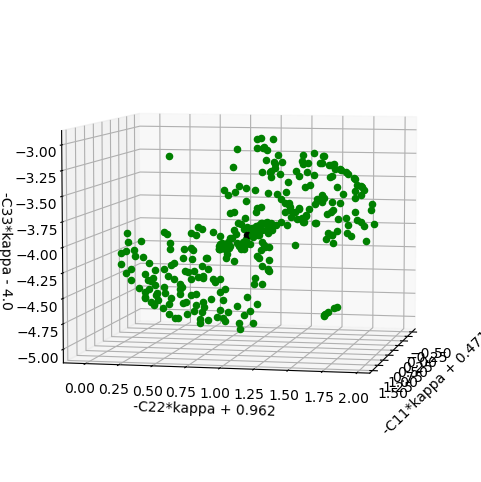

In [15]:
# %matplotlib widget
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.view_init(6, 12, 0) #elev, azim, roll
# ax.view_init(49, -77, 0)
# ax.view_init(5, -178, 0)
ax.scatter(J_sub_k[0], J_sub_k[1], J_sub_k[2], c='black')
x_lams = []
for i in range(len(C_k)):
    params = [C_k[i], J_k[i]]
    expr = -C_k[i]*1.0 + J_k[i]
    x_lam = sy.lambdify(params, expr, 'numpy')
    x_lams.append(x_lam)
for i in range(len(data[sy.sstr(C_k[0])])):
    wav_nonan = [val for val in data['kappa_cs']['wav'][i] if not np.isnan(val)]
    st_nonan = [val for val in data['kappa_cs']['st'][i] if not np.isnan(val)]
    wav = len(wav_nonan) > 0
    st = len(st_nonan) > 0
    if (len(wav_nonan) > 0) and (len(st_nonan) > 0):
        wav_before_st = min(wav_nonan) < min(st_nonan)
        st_before_wav = min(st_nonan) < min(wav_nonan)
    else:
        wav_before_st = wav
        st_before_wav = st
    # if wav_before_st:
    #     coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j])) for j, x_lam in enumerate(x_lams)]
    #     ax.scatter(*zip(coords), c='pink')
    # elif st_before_wav:
    #     coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j])) for j, x_lam in enumerate(x_lams)]
    #     ax.scatter(*zip(coords), c='cyan')
    if (wav == False) and (st == False):
        coords = [x_lam(data[sy.sstr(C_k[j])][i], float(J_sub_k[j])) for j, x_lam in enumerate(x_lams)]
        ax.scatter(*zip(coords), c='green')
ax.set_xlabel(M_sub_k[0])
ax.set_ylabel(M_sub_k[1])
ax.set_zlabel(M_sub_k[2])

In [13]:
path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
fn = 'volume_C23gt0_side.png'
fig.savefig(path + fn)